In [ ]:
!pip install torch torchvision torchaudio chess pytorch-lightning opencv-python



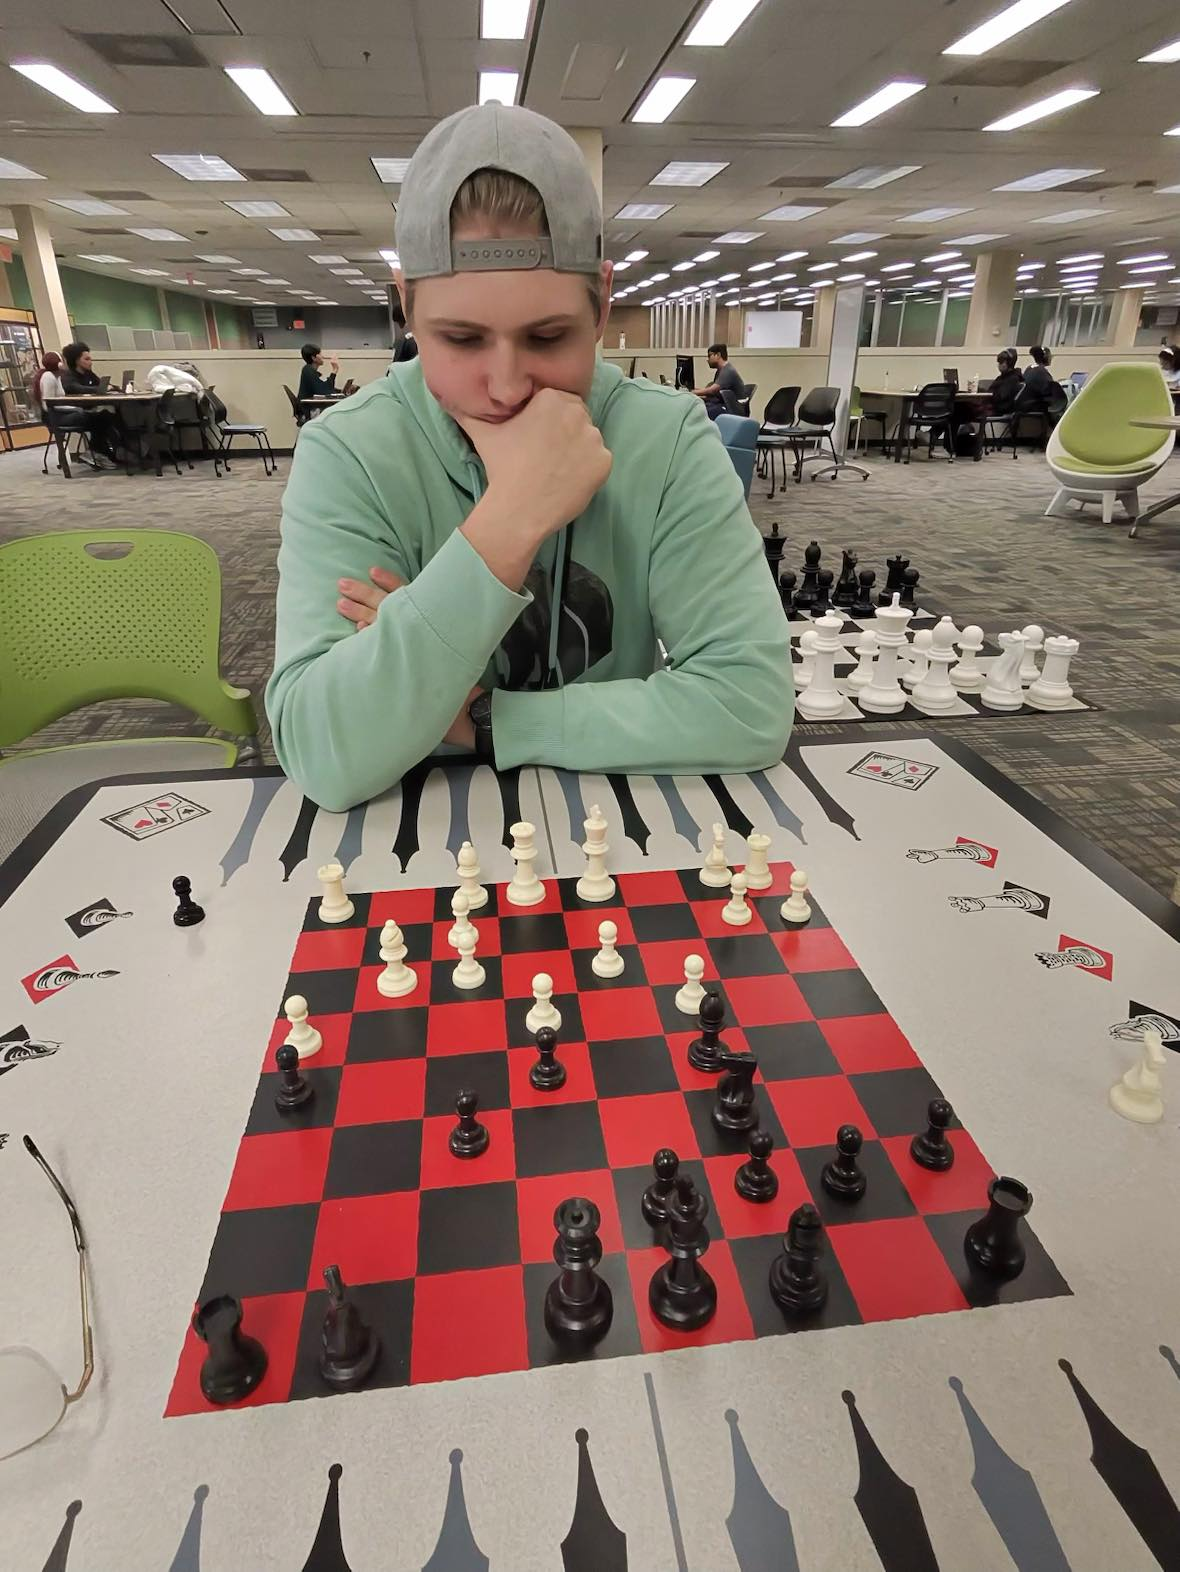

In [2]:
#import images

from stockfish import Stockfish as sf
from torch import torch
import os
import chess.svg
from IPython.display import display, SVG, Image
from prediction import BoardPredictor

# Set paths
model_file_path = "2023-11-02-fenify-3d-efficientnet-v2-s-95-val-acc.pt"  # Your model file
image_folder = "testing"  # Change to your actual folder name

image_name = "w10.jpg"

image_path = os.path.join(image_folder, image_name)
# Ensure the file exists
if not os.path.exists(image_path):
    print(f"Image {image_name} not found.")

image = Image(filename=image_path) 
image

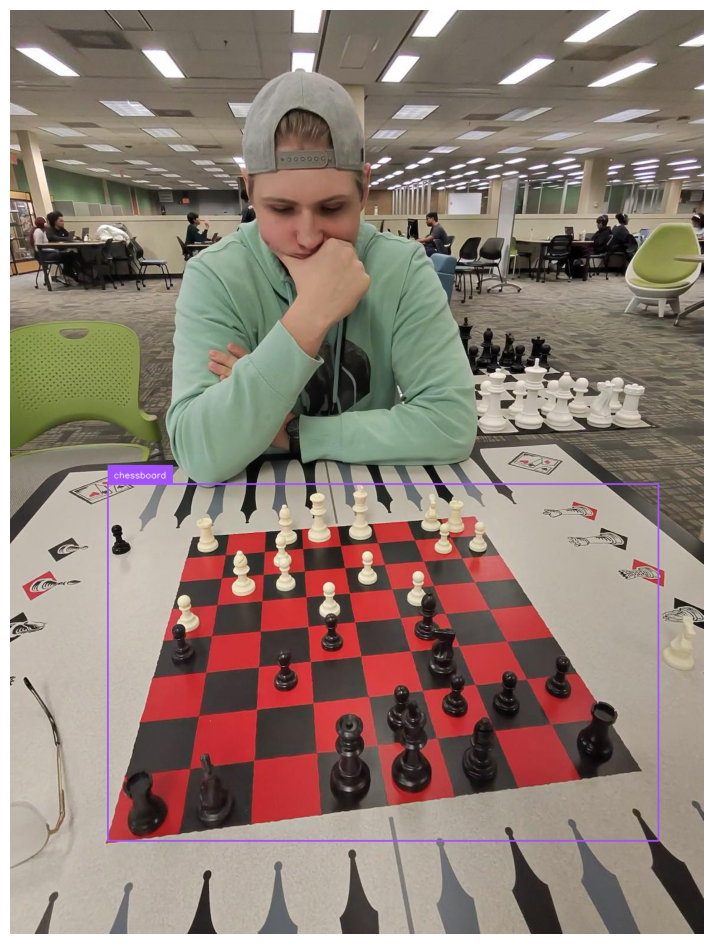

In [3]:

# recgonition

from inference import get_model
import supervision as sv
import cv2

ROBOFLOW_API_KEY = "0TZCOOSlxe8D7RJxpxuB" 
def generateboundingbox(image_path):
    # define the image url to use for inference
    image = cv2.imread(image_path)
    
    # load a pre-trained yolov8n model
    model = get_model(model_id="chessboard-object-detection/1", api_key=ROBOFLOW_API_KEY)
    
    # run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
    results = model.infer(image)[0]
    
    # load the results into the supervision Detections api
    detections = sv.Detections.from_inference(results)
    
    # create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    # annotate the image with our inference results
    annotated_image = bounding_box_annotator.annotate(
        scene=image, detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections)

    return detections, image

# display the image
_, annotated_image = generateboundingbox(image_path)
sv.plot_image(annotated_image)


In [4]:
# Extract bounding box coordinates (x_min, y_min, x_max, y_max)
def bounding_box_cropping(detections, image): 
    for x_min, y_min, x_max, y_max in detections.xyxy:  
        # Convert to integer
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        
        # Crop the image to the bounding box
        cropped_image = image[y_min:y_max, x_min:x_max]
        
        # Save or display the cropped image
        cv2.imwrite("cropped_image.jpg", cropped_image)
        sv.plot_image(cropped_image)
        return cropped_image

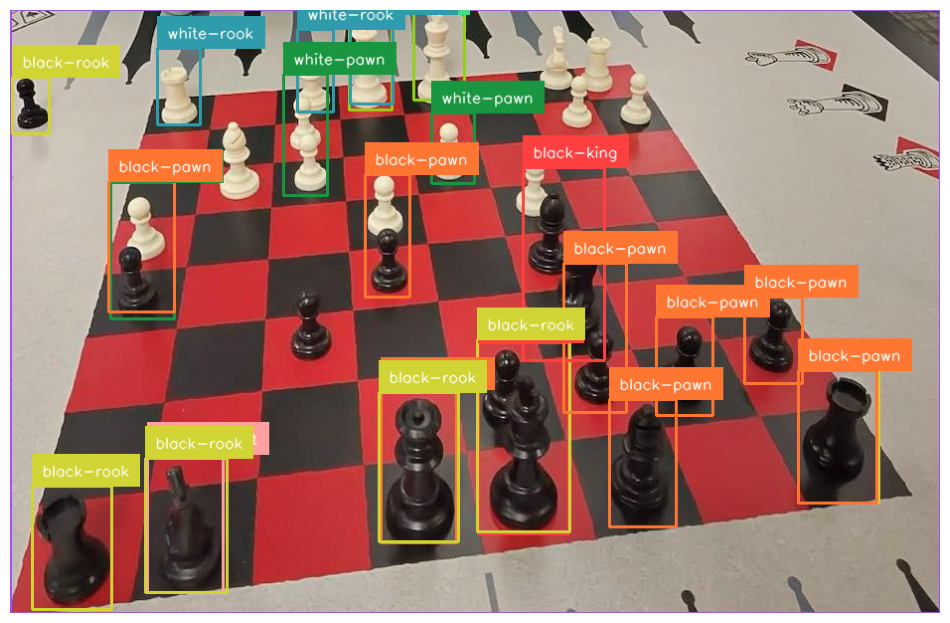

In [5]:
# define the image url to use for inference
image = cv2.imread("cropped_image.jpg")

# load a pre-trained yolov8n model
model = get_model(model_id="chesspiece-detection-twhpv/5", api_key=ROBOFLOW_API_KEY)

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)


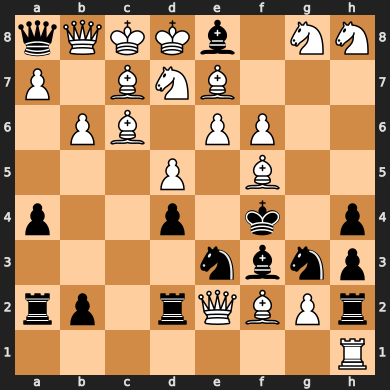

qQKKb1NN/P1BNB3/1PB1PP2/3P1B2/p2p1k1p/4nbnp/rp1rQBPr/7R w - - 0 1


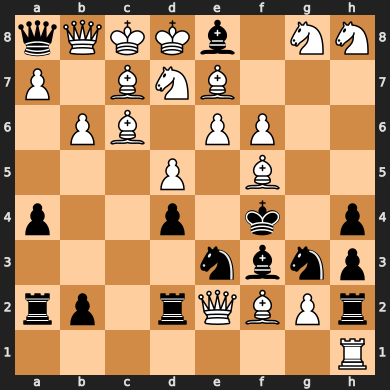

In [20]:
# Load the predictor
predictor = BoardPredictor(model_file_path)

def predict_and_display(image_name):
    """Predicts the chessboard from an image and displays the SVG."""
    
    # Perform prediction
    predicted_board = predictor.predict(image_path)

    # Generate SVG
    board_svg = chess.svg.board(board=predicted_board)

    # Display the SVG in the notebook
    display(SVG(board_svg))
    print(predicted_board.fen())
    return predicted_board.fen()

# Example: Predict and display for a specific image
predict_and_display("cropped_image.jpg")  # Change "w0.jpg" to any filename you want

In [80]:
def validation(predicted_board, FEN_boards, turn):
    previous_board = chess.Board(FEN_boards[turn - 1])  # Get previous board position
    predicted_fen = predicted_board.fen()  # Get FEN of predicted board
    
    for move in previous_board.pseudo_legal_moves:  # Iterate over pseudo-legal moves
        new_board = previous_board.copy()  # Copy board to apply move
        new_board.push(move)  # Make the move
        
        if new_board.fen() == predicted_fen:  # Compare FENs
            return True  # Valid position
    
    return False  # If no matching FEN found, invalid position

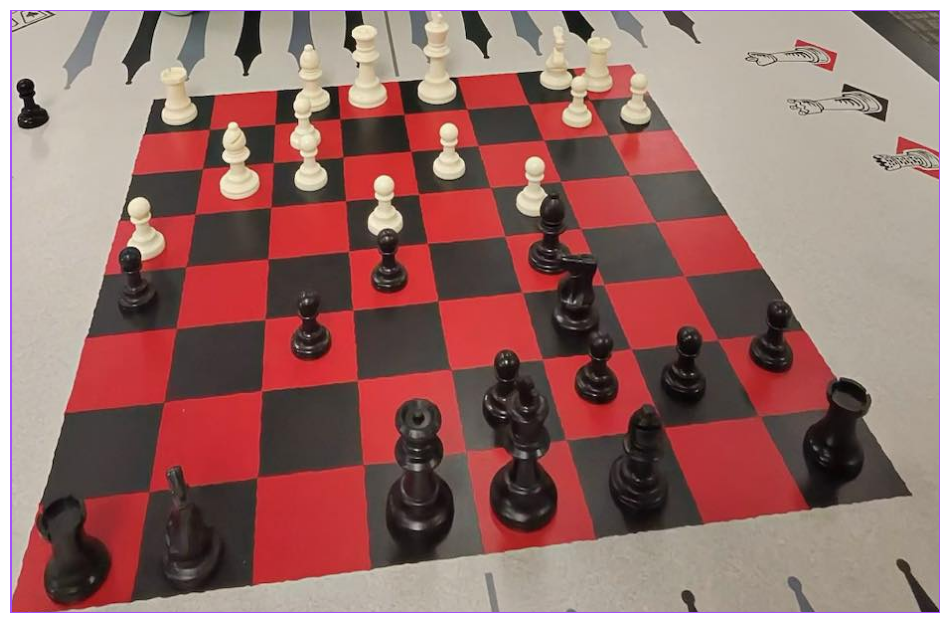

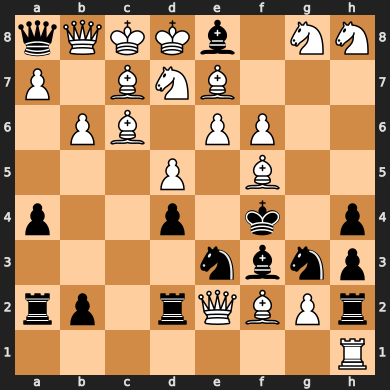

qQKKb1NN/P1BNB3/1PB1PP2/3P1B2/p2p1k1p/4nbnp/rp1rQBPr/7R w - - 0 1
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


In [82]:
from stockfish import Stockfish as sf
from torch import torch
import os
import chess.svg
import chess
from IPython.display import display, SVG, Image
from prediction import BoardPredictor
from inference import get_model
import supervision as sv
import numpy as np
import cv2

ROBOFLOW_API_KEY = "0TZCOOSlxe8D7RJxpxuB" 
class IMG_to_FEN():
    def __init__(self):
        self.FEN_boards = [""]
        self.turn = 0
        self.FEN_boards[0] = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"

    def fenCodeFromImage(self, image_path):
        
        detections, image = generateboundingbox(image_path)
        cropped_image = bounding_box_cropping(detections, image)
        predictor = BoardPredictor(model_file_path)
        fen_code = predict_and_display(cropped_image)
        if validation(fen_code, self.FEN_boards, turn):
            self.FEN_boards.append(fen_code)
            self.turn += 1
            return fen_code
        else: return self.FEN_boards[turn - 1]
        
image_folder = "testing"  # Change to your actual folder name

image_name = "w10.jpg"

image_path = os.path.join(image_folder, image_name)
# Ensure the file exists
if not os.path.exists(image_path):
    print(f"Image {image_name} not found.")

img = IMG_to_FEN()

code = img.fenCodeFromImage(image_path)
print(code)